In [67]:
import json
import keras.layers as layers
import numpy as np
import pandas as pd
import spacy
from gensim.corpora import Dictionary
from keras.models import Model
from keras.preprocessing import sequence
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from spacy.util import minibatch
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle

In [68]:
data = pd.read_json('News_Category_Dataset_v2.json', lines=True)
items = pd.read_csv('items.csv')

len(data)

200853

In [69]:
data

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26
...,...,...,...,...,...,...
200848,TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,"Reuters, Reuters",https://www.huffingtonpost.com/entry/rim-ceo-t...,Verizon Wireless and AT&T are already promotin...,2012-01-28
200849,SPORTS,Maria Sharapova Stunned By Victoria Azarenka I...,,https://www.huffingtonpost.com/entry/maria-sha...,"Afterward, Azarenka, more effusive with the pr...",2012-01-28
200850,SPORTS,"Giants Over Patriots, Jets Over Colts Among M...",,https://www.huffingtonpost.com/entry/super-bow...,"Leading up to Super Bowl XLVI, the most talked...",2012-01-28
200851,SPORTS,Aldon Smith Arrested: 49ers Linebacker Busted ...,,https://www.huffingtonpost.com/entry/aldon-smi...,CORRECTION: An earlier version of this story i...,2012-01-28


In [70]:
data.drop_duplicates(inplace=True)

# WORLDPOST and THE WORLDPOST were given as two separate categories in the dataset.
data.category = data.category.map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x)

len(data)

200840

In [71]:
# Cálculo do comprimento dos textos das colunas 'headline' e 'short_description' do 
# dataset News_Category_Dataset_v2 e da coluna 'new_title' no dataset items
descr_len = data['short_description'].apply(lambda x: len(str(x).split()))
headline_len = data['headline'].apply(lambda x: len(str(x).split()))
title_len = items['new_title'].apply(lambda x: len(str(x).split()))

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


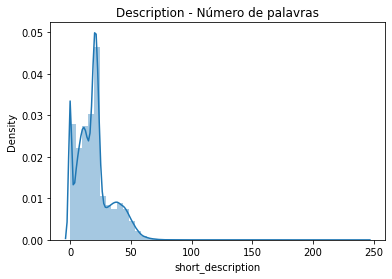

In [72]:
sns.distplot(descr_len)
plt.title('Description - Número de palavras')
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


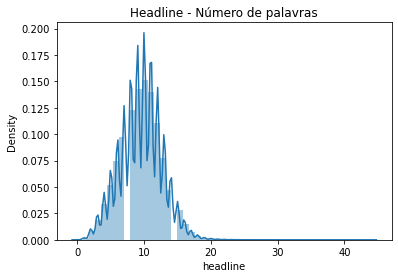

In [73]:
sns.distplot(headline_len)
plt.title('Headline - Número de palavras')
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


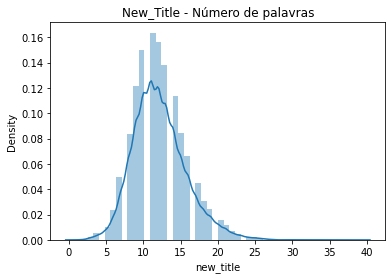

In [74]:
sns.distplot(title_len)
plt.title('New_Title - Número de palavras')
plt.show()

In [75]:
# Selecionadas apenas as colunas necessárias
data = data[['headline','category']].copy()

In [76]:
print(f"The dataset contains { data.category.nunique() } unique categories")
categories = data.groupby('category').size().sort_values(ascending=False)
categories

The dataset contains 40 unique categories


category
POLITICS          32738
WELLNESS          17824
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9646
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
WORLDPOST          6243
FOOD & DRINK       6226
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
PARENTS            3955
WEDDINGS           3651
WOMEN              3489
IMPACT             3459
DIVORCE            3426
CRIME              3405
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
RELIGION           2556
STYLE              2254
SCIENCE            2178
WORLD NEWS         2177
TASTE              2096
TECH               2078
MONEY              1707
ARTS               1509
FIFTY              1401
GOOD NEWS          1398
ARTS & CULTURE     1339
ENVIRONMENT        1322
COLLEGE            1144
LATINO VOICES      1129
CULTURE & ARTS     1030
EDUCATION          1004
dtype: int64

In [77]:
cat_select = categories[:15]
cat_select

category
POLITICS          32738
WELLNESS          17824
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9646
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
WORLDPOST          6243
FOOD & DRINK       6226
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
dtype: int64

In [79]:
cat_select = cat_select[~cat_select.index.isin(['PARENTING', 'HEALTHY LIVING', 'BUSINESS', 'COMEDY', 'BLACK VOICES', 'WORLDPOST'])]
cat_select

category
POLITICS          32738
WELLNESS          17824
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9646
QUEER VOICES       6314
FOOD & DRINK       6226
SPORTS             4884
HOME & LIVING      4195
dtype: int64

In [80]:
# após seleção das categorias pretendidas
categories = cat_select
N_CATEGORIES = len(categories)

# filtra o dataset para as categorias pretendidas e retira todos os textos sem palavras
data = data[data.category.apply(lambda x: x in categories.index[:N_CATEGORIES]) &\
            (data.headline.apply(len) > 0)]

# separação treino-teste (80%-20%)
data_train, data_test = train_test_split(data, test_size=.2, random_state=23)

print(f'Tamanhos => data_train: {len(data_train)} ; data_test: {len(data_test)}; total data: {len(data)}')

Tamanhos => data_train: 86216 ; data_test: 21554; total data: 107770


# Tratamento do input para o modelo CNN

In [23]:
MAX_SEQUENCE_LEN = 40
UNK = 'UNK' # unknown tokens
PAD = 'PAD' # padding tokens

def text_to_id_list(text, dictionary):
    return [dictionary.token2id.get(tok, dictionary.token2id.get(UNK))
            for tok in text_to_tokens(text)]

def texts_to_input(texts, dictionary):
    return sequence.pad_sequences(
        list(map(lambda x: text_to_id_list(x, dictionary), texts)), maxlen=MAX_SEQUENCE_LEN,
        padding='post', truncating='post', value=dictionary.token2id.get(PAD))

def text_to_tokens(text):
    return [tok.text.lower() for tok in nlp.tokenizer(text)
            if not (tok.is_punct or tok.is_quote)]

def build_dictionary(texts):
    d = Dictionary(text_to_tokens(t)for t in texts)
    d.filter_extremes(no_below=3, no_above=1)
    d.add_documents([[UNK, PAD]])
    d.compactify()
    return d

In [24]:
nlp = spacy.load('en_core_web_sm')
dictionary = build_dictionary(data.headline)

In [27]:
# Exporta o dictionário construido
with open('TC_dictionary.data', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(dictionary, filehandle)

In [28]:
len_dict = len(dictionary)
list1 = list(range(20))
list2 = list(range(len_dict-20,len_dict))
list1 += list2

print([dictionary[i] for i in list1])

["'s", '2018', 'and', 'cup', 'diplo', 'for', 'jam', 'joins', 'nicky', 'official', 'smith', 'song', 'the', 'will', 'world', '57', 'age', 'at', 'first', 'grant', 'sozzani', 'alber', 'elbaz', 'gingham', 'qnexa', 'garance', 'lehigh', 'creighton', 'norfolk', 'marni', 'install', 'leroy', 'blahnik', 'manolo', 'understated', 'glittering', 'amani', 'toomer', 'PAD', 'UNK']


In [29]:
x_train = texts_to_input(data_train.headline, dictionary)
x_test = texts_to_input(data_test.headline, dictionary)

In [30]:
x_train.shape, x_test.shape

((86216, 40), (21554, 40))

In [31]:
# Label encoding das categorias
lb = LabelBinarizer()
lb.fit(categories.index[:N_CATEGORIES])

y_train = lb.transform(data_train.category)
y_test = lb.transform(data_test.category)

In [43]:
# Exporta o label binarizer
with open('labelbinarizer.data', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(lb, filehandle)

# Modelo CNN

In [78]:
EMBEDDING_DIM = 40

inp = layers.Input(shape=(MAX_SEQUENCE_LEN,), dtype='float32')
emb = layers.Embedding(len(dictionary), EMBEDDING_DIM, input_length=MAX_SEQUENCE_LEN)(inp)
filters = []
for kernel_size in [2, 3, 4]:
    conv = layers.Conv1D(32, kernel_size, padding='same', activation='relu', strides=1)(emb)
    pooled = layers.MaxPooling1D(pool_size=MAX_SEQUENCE_LEN-kernel_size+1)(conv)
    filters.append(pooled)

stacked = layers.Concatenate()(filters)
flatten = layers.Flatten()(stacked)
drop = layers.Dropout(0.2)(flatten)
out = layers.Dense(N_CATEGORIES, activation='softmax')(drop)

model = Model(inputs=inp, outputs=out)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [79]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 40, 40)       789160      input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 40, 32)       2592        embedding_4[0][0]                
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 40, 32)       3872        embedding_4[0][0]                
____________________________________________________________________________________________

In [80]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, patience=50, min_lr=0.00005)]

model.fit(x_train, y_train, epochs=200, batch_size=128, validation_data=(x_test, y_test), callbacks=callbacks)

Epoch 1/200
674/674 [==============================] - 14s 18ms/step - loss: 1.5314 - accuracy: 0.4760 - val_loss: 0.6153 - val_accuracy: 0.8140
Epoch 2/200
674/674 [==============================] - 12s 18ms/step - loss: 0.5015 - accuracy: 0.8517 - val_loss: 0.5231 - val_accuracy: 0.8430
Epoch 3/200
674/674 [==============================] - 12s 18ms/step - loss: 0.3358 - accuracy: 0.9011 - val_loss: 0.5206 - val_accuracy: 0.8471
Epoch 4/200
674/674 [==============================] - 12s 18ms/step - loss: 0.2598 - accuracy: 0.9216 - val_loss: 0.5483 - val_accuracy: 0.8434
Epoch 5/200
674/674 [==============================] - 12s 18ms/step - loss: 0.1991 - accuracy: 0.9422 - val_loss: 0.5916 - val_accuracy: 0.8378
Epoch 6/200
674/674 [==============================] - 12s 18ms/step - loss: 0.1625 - accuracy: 0.9515 - val_loss: 0.6326 - val_accuracy: 0.8355
Epoch 7/200
674/674 [==============================] - 12s 17ms/step - loss: 0.1338 - accuracy: 0.9598 - val_loss: 0.6813 - val_ac

In [81]:
y_test_pred = [lb.classes_[i] for i in np.argmax(model.predict(x_test), axis=1)]
classif_report = classification_report(data_test.category, y_test_pred)

print(classification_report(data_test.category, y_test_pred))

                precision    recall  f1-score   support

 ENTERTAINMENT       0.77      0.79      0.78      3219
  FOOD & DRINK       0.78      0.74      0.76      1297
 HOME & LIVING       0.74      0.70      0.72       836
      POLITICS       0.88      0.89      0.88      6491
  QUEER VOICES       0.71      0.68      0.70      1228
        SPORTS       0.76      0.68      0.72      1014
STYLE & BEAUTY       0.79      0.83      0.81      1969
        TRAVEL       0.78      0.80      0.79      1955
      WELLNESS       0.80      0.80      0.80      3545

      accuracy                           0.81     21554
     macro avg       0.78      0.77      0.77     21554
  weighted avg       0.81      0.81      0.81     21554



In [82]:
model.save('CNN_topic_category_topCats')

INFO:tensorflow:Assets written to: CNN_topic_category_topCats/assets


___

In [45]:
tf.saved_model.contains_saved_model('CNN_topic_category_topCats')

True

In [46]:
from tensorflow import keras
model = tf.keras.models.load_model('CNN_topic_category_topCats')

In [47]:
# tratamento do items['new_title'] para input da CNN
titles2input = texts_to_input(items.new_title, dictionary)
titles2input.shape

(23932, 40)

In [48]:
# previsão que devolve as probabilidades de ser cada uma das categorias
prob_cats = model.predict(titles2input)

In [49]:
from scipy import stats
# verificar qual a maior probabilidade para cada título para analisar limites
max_args = [np.amax(i) for i in prob_cats]
stats.describe(max_args)

DescribeResult(nobs=23932, minmax=(0.23465323, 1.0), mean=0.9518122, variance=0.012982228, skewness=-2.781637191772461, kurtosis=7.277572615576277)

In [50]:
# Com o limite definido quantos elementos passarão a ter classificação 'OTHERS'
limite = 0.7
count = 0
for i in max_args:
    if i >= limite:
        count += 1
print(f'#OTHERS = {count} de {len(max_args)}')

#OTHERS = 22425 de 23932


In [51]:
for i in range(len(lb.classes_)):
    print(f'{i} => {lb.classes_[i]}')

0 => ENTERTAINMENT
1 => FOOD & DRINK
2 => HOME & LIVING
3 => POLITICS
4 => QUEER VOICES
5 => SPORTS
6 => STYLE & BEAUTY
7 => TRAVEL
8 => WELLNESS


In [52]:
# confirmação
inf_limit = 0.7
predicted_cats = list()
for i in prob_cats:
    if np.amax(i) >= inf_limit:
        predicted_cats.append(lb.classes_[np.argmax(i)])
    else:
        predicted_cats.append('OTHERS')

predicted_cats

['POLITICS',
 'POLITICS',
 'POLITICS',
 'QUEER VOICES',
 'POLITICS',
 'POLITICS',
 'TRAVEL',
 'ENTERTAINMENT',
 'WELLNESS',
 'POLITICS',
 'ENTERTAINMENT',
 'POLITICS',
 'WELLNESS',
 'POLITICS',
 'ENTERTAINMENT',
 'ENTERTAINMENT',
 'SPORTS',
 'POLITICS',
 'POLITICS',
 'QUEER VOICES',
 'QUEER VOICES',
 'POLITICS',
 'POLITICS',
 'WELLNESS',
 'POLITICS',
 'POLITICS',
 'TRAVEL',
 'TRAVEL',
 'POLITICS',
 'SPORTS',
 'POLITICS',
 'POLITICS',
 'SPORTS',
 'POLITICS',
 'TRAVEL',
 'POLITICS',
 'POLITICS',
 'POLITICS',
 'POLITICS',
 'POLITICS',
 'ENTERTAINMENT',
 'TRAVEL',
 'POLITICS',
 'POLITICS',
 'POLITICS',
 'POLITICS',
 'POLITICS',
 'POLITICS',
 'POLITICS',
 'SPORTS',
 'POLITICS',
 'POLITICS',
 'POLITICS',
 'SPORTS',
 'FOOD & DRINK',
 'POLITICS',
 'POLITICS',
 'POLITICS',
 'POLITICS',
 'WELLNESS',
 'POLITICS',
 'WELLNESS',
 'POLITICS',
 'POLITICS',
 'HOME & LIVING',
 'POLITICS',
 'SPORTS',
 'POLITICS',
 'TRAVEL',
 'TRAVEL',
 'ENTERTAINMENT',
 'POLITICS',
 'OTHERS',
 'POLITICS',
 'TRAVEL',
 'TR

In [53]:
pred_cats_S = pd.Series(predicted_cats)
pred_cats_S

0             POLITICS
1             POLITICS
2             POLITICS
3         QUEER VOICES
4             POLITICS
             ...      
23927         WELLNESS
23928         POLITICS
23929    ENTERTAINMENT
23930         POLITICS
23931         WELLNESS
Length: 23932, dtype: object

In [54]:
items

,news_id,newsoutlet_id,news_tweet_date,news_url,new_title,news_date,news_text
0,1079995915652476928,28785486,2019-01-01 07:01:06,https://abcn.ws/2CIbHpE,China factory activity shrinks for the first t...,NaN,China's factory activity shrank in December fo...
1,1084275179331772416,28785486,2019-01-13 02:25:22,https://abcn.ws/2Fv3iri,Drone captures California man surfing with dol...,NaN,"Breathtaking drone video of a pod of friendly,..."
2,1080216134467702784,28785486,2019-01-01 21:36:10,https://abcn.ws/2CHWRj9,"In 'unprecedented' speech, Kim Jong Un says No...",NaN,Kim Jong Un says he is ready to sit down again...
3,1080901028365697026,28785486,2019-01-03 18:57:41,https://abcn.ws/2CMaEVD,"Reward grows to $75,000 in hunt for killer of ...",NaN,A reward for information leading to the arrest...
4,1081379589711167489,28785486,2019-01-05 02:39:19,https://abcn.ws/2CPxBr3,GOP decries Pelosi's muted reaction as Dems de...,NaN,As newly minted Rep. Rashida Tlaib refused to ...
...,...,...,...,...,...,...,...
23927,1082325977840136193,6107422,2019-01-07 17:19:56,https://www.thetimes.co.uk/article/a-e-patient...,Doctors warn NHS chief not to ditch A&E waitin...,NaN,Doctors have warned the head of the NHS not to...
23928,1079999842125078528,6107422,2019-01-01 07:16:42,https://www.thetimes.co.uk/article/world-welco...,"World welcomes in new year with a smash, bang ...",NaN,Fireworks lit up the London Eye as thousands o...
23929,1081112020659945472,6107422,2019-01-04 08:56:06,https://www.thetimes.co.uk/article/stalker-who...,Stalker who threatened to rape BBC’s Alex Love...,NaN,The BBC presenter Alex Lovell spent two years ...
23930,1083018693053960192,6107422,2019-01-09 15:12:32,https://www.thetimes.co.uk/article/jorja-emers...,"Jorja Emerson, the first child prescribed cann...",NaN,Sick children still face unacceptable obstacle...


In [56]:
items['Topic_Categories'] = pred_cats_S
items[['news_text', 'Topic_Categories']]

,news_text,Topic_Categories
0,China's factory activity shrank in December fo...,POLITICS
1,"Breathtaking drone video of a pod of friendly,...",POLITICS
2,Kim Jong Un says he is ready to sit down again...,POLITICS
3,A reward for information leading to the arrest...,QUEER VOICES
4,As newly minted Rep. Rashida Tlaib refused to ...,POLITICS
...,...,...
23927,Doctors have warned the head of the NHS not to...,WELLNESS
23928,Fireworks lit up the London Eye as thousands o...,POLITICS
23929,The BBC presenter Alex Lovell spent two years ...,ENTERTAINMENT
23930,Sick children still face unacceptable obstacle...,POLITICS


In [57]:
y = pd.get_dummies(items.Topic_Categories, prefix='TC')
y

,TC_ENTERTAINMENT,TC_FOOD & DRINK,TC_HOME & LIVING,TC_OTHERS,TC_POLITICS,TC_QUEER VOICES,TC_SPORTS,TC_STYLE & BEAUTY,TC_TRAVEL,TC_WELLNESS
0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
23927,0,0,0,0,0,0,0,0,0,1
23928,0,0,0,0,1,0,0,0,0,0
23929,1,0,0,0,0,0,0,0,0,0
23930,0,0,0,0,1,0,0,0,0,0


In [58]:
topic_cats = pd.merge(items.news_id, y, left_index=True, right_index=True)
topic_cats

,news_id,TC_ENTERTAINMENT,TC_FOOD & DRINK,TC_HOME & LIVING,TC_OTHERS,TC_POLITICS,TC_QUEER VOICES,TC_SPORTS,TC_STYLE & BEAUTY,TC_TRAVEL,TC_WELLNESS
0,1079995915652476928,0,0,0,0,1,0,0,0,0,0
1,1084275179331772416,0,0,0,0,1,0,0,0,0,0
2,1080216134467702784,0,0,0,0,1,0,0,0,0,0
3,1080901028365697026,0,0,0,0,0,1,0,0,0,0
4,1081379589711167489,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
23927,1082325977840136193,0,0,0,0,0,0,0,0,0,1
23928,1079999842125078528,0,0,0,0,1,0,0,0,0,0
23929,1081112020659945472,1,0,0,0,0,0,0,0,0,0
23930,1083018693053960192,0,0,0,0,1,0,0,0,0,0


In [96]:
topic_cats.to_csv('topic_cats.csv', index=False)

# Predict de um único texto

In [3]:
from tensorflow import keras
model = tf.keras.models.load_model('CNN_topic_category_topCats')

In [6]:
texto = items.new_title[0]
texto

'China factory activity shrinks for the first time in 2 years'

In [32]:
with open('TC_dictionary.data', 'rb') as filehandle:
    dictionary = pickle.load(filehandle)

nlp = spacy.load('en_core_web_sm')

In [33]:
ttl2input = texts_to_input(pd.Series(texto), dictionary)
ttl2input.shape

(1, 40)

In [34]:
#y_test_pred = [lb.classes_[i] for i in np.argmax(model.predict(x_test), axis=1)]
limite = 0.7

y_predicted = model.predict(ttl2input)
if np.amax(y_predicted)>= limite:
    res = lb.classes_[np.argmax(y_predicted)]
else:
    res = 'OTHERS'
res

'POLITICS'

### Várias linhas

In [38]:
textos = items.new_title[0:2]
textos

0    China factory activity shrinks for the first t...
1    Drone captures California man surfing with dol...
Name: new_title, dtype: object

In [39]:
ttl2input_2 = texts_to_input(pd.Series(textos), dictionary)
ttl2input_2.shape

(2, 40)

In [41]:
y_predicted = model.predict(ttl2input_2)
y_predicted

array([[1.6783777e-15, 1.2015964e-18, 2.9164258e-17, 9.9903691e-01,
        9.5863774e-04, 1.4667881e-12, 1.7527959e-15, 1.2051310e-18,
        4.5841225e-06],
       [3.3098722e-11, 2.6064151e-19, 6.4493214e-17, 9.9982494e-01,
        3.6246083e-16, 1.7512833e-04, 1.6781217e-20, 2.7670570e-08,
        4.1473389e-22]], dtype=float32)

In [42]:
res = list()
for pred in y_predicted:
    if np.amax(pred)>= limite:
        res.append(lb.classes_[np.argmax(pred)])
    else:
        res.append('OTHERS')
cat = pd.Series(res)


0    POLITICS
1    POLITICS
dtype: object